# Notebook 02: COG Enrichment Analysis by Lifestyle

**Project**: Lifestyle-Based COG Stratification

**Goal**: Compare COG functional enrichment patterns (core vs accessory) between host-associated and free-living species.

**Hypotheses**:
- H1: Host-associated bacteria have higher defense (COG V) enrichment in accessory genes
- H2: Free-living bacteria have greater metabolic diversity (COG E,G,C,P,I) in accessory genes
- H3: Host-associated bacteria have smaller core genome fractions

**Input**: `../data/species_lifestyle_classification.csv` (from Notebook 01)

**Output**: `../data/cog_enrichment_by_lifestyle.csv`, `../figures/enrichment_heatmap.png`

In [1]:
spark = get_spark_session()
import pandas as pd
import numpy as np

In [2]:
# Load species lifestyle classification from Notebook 01
species_df = pd.read_csv('../data/species_lifestyle_classification.csv')
print(f"Total target species: {len(species_df)}")
print(species_df['species_lifestyle'].value_counts())

species_list = species_df['gtdb_species_clade_id'].tolist()
print(f"\nSpecies IDs loaded: {len(species_list)}")

Total target species: 2529
species_lifestyle
host_associated    1705
free_living         824
Name: count, dtype: int64

Species IDs loaded: 2529


## 1. COG Distribution: Core vs Accessory per Species

For each target species, query `gene_cluster` joined with `eggnog_mapper_annotations` to get
COG category counts by core/accessory status.

**Safety**: Always filter by `gtdb_species_clade_id` — these are large tables.

In [3]:
# Process species in batches to manage memory
# Batch size depends on species pangenome size; 10-20 species per batch is safe
BATCH_SIZE = 20

all_results = []

for i in range(0, len(species_list), BATCH_SIZE):
    batch = species_list[i:i + BATCH_SIZE]
    # Escape single quotes in species IDs (shouldn't be needed but safe)
    in_clause = "', '".join(batch)
    
    batch_result = spark.sql(f"""
        SELECT
            gc.gtdb_species_clade_id,
            gc.is_core,
            ann.COG_category,
            COUNT(*) as cluster_count
        FROM kbase_ke_pangenome.gene_cluster gc
        JOIN kbase_ke_pangenome.eggnog_mapper_annotations ann
            ON gc.gene_cluster_id = ann.query_name
        WHERE gc.gtdb_species_clade_id IN ('{in_clause}')
            AND ann.COG_category IS NOT NULL
            AND ann.COG_category != '-'
        GROUP BY gc.gtdb_species_clade_id, gc.is_core, ann.COG_category
        ORDER BY gc.gtdb_species_clade_id, gc.is_core, cluster_count DESC
    """)
    
    all_results.append(batch_result.toPandas())
    print(f"Batch {i // BATCH_SIZE + 1}/{(len(species_list) + BATCH_SIZE - 1) // BATCH_SIZE}: "
          f"{len(batch)} species, {len(all_results[-1])} rows")

cog_raw = pd.concat(all_results, ignore_index=True)
print(f"\nTotal COG rows: {len(cog_raw):,}")
print(f"Species with data: {cog_raw['gtdb_species_clade_id'].nunique()}")
cog_raw.head(10)

Batch 1/127: 20 species, 2914 rows
Batch 2/127: 20 species, 2431 rows
Batch 3/127: 20 species, 2544 rows
Batch 4/127: 20 species, 2728 rows
Batch 5/127: 20 species, 2582 rows
Batch 6/127: 20 species, 2217 rows
Batch 7/127: 20 species, 2273 rows
Batch 8/127: 20 species, 2249 rows
Batch 9/127: 20 species, 2357 rows
Batch 10/127: 20 species, 2286 rows
Batch 11/127: 20 species, 2255 rows
Batch 12/127: 20 species, 2192 rows
Batch 13/127: 20 species, 2261 rows
Batch 14/127: 20 species, 2119 rows
Batch 15/127: 20 species, 2345 rows
Batch 16/127: 20 species, 2346 rows
Batch 17/127: 20 species, 2299 rows
Batch 18/127: 20 species, 2245 rows
Batch 19/127: 20 species, 2188 rows
Batch 20/127: 20 species, 2056 rows
Batch 21/127: 20 species, 2236 rows
Batch 22/127: 20 species, 2043 rows
Batch 23/127: 20 species, 2235 rows
Batch 24/127: 20 species, 2212 rows
Batch 25/127: 20 species, 2169 rows
Batch 26/127: 20 species, 2196 rows
Batch 27/127: 20 species, 2101 rows
Batch 28/127: 20 species, 2120 rows
B

,gtdb_species_clade_id,is_core,COG_category,cluster_count
0,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,S,9956
1,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,L,6407
2,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,K,3171
3,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,C,2718
4,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,E,2400
5,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,M,2393
6,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,P,1948
7,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,J,1588
8,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,I,1428
9,s__Acinetobacter_baumannii--RS_GCF_009759685.1,False,G,1260


## 2. Handle Multi-Character COG Categories

Some genes have composite COG categories (e.g., "LV", "EGP").
Split these so each character is counted separately, then normalize.

In [4]:
# Check how common multi-character COG categories are
cog_raw['cog_len'] = cog_raw['COG_category'].str.len()
print("COG category length distribution:")
print(cog_raw.groupby('cog_len')['cluster_count'].sum())
print(f"\nMulti-char fraction: {cog_raw[cog_raw['cog_len'] > 1]['cluster_count'].sum() / cog_raw['cluster_count'].sum():.1%}")

COG category length distribution:
cog_len
1    13372111
2      793347
3      130302
4        1589
5         279
Name: cluster_count, dtype: int64

Multi-char fraction: 6.5%


In [5]:
# Split multi-character COG categories into individual characters
# Each character gets the full count (gene is counted in each category)
rows = []
for _, row in cog_raw.iterrows():
    for char in row['COG_category']:
        if char.isalpha():  # Skip any non-letter characters
            rows.append({
                'gtdb_species_clade_id': row['gtdb_species_clade_id'],
                'is_core': row['is_core'],
                'COG_category': char,
                'cluster_count': row['cluster_count']
            })

cog_split = pd.DataFrame(rows)

# Aggregate after splitting
cog_agg = cog_split.groupby(
    ['gtdb_species_clade_id', 'is_core', 'COG_category']
)['cluster_count'].sum().reset_index()

print(f"After splitting: {len(cog_agg):,} rows")
print(f"Unique COG categories: {sorted(cog_agg['COG_category'].unique())}")

After splitting: 102,757 rows
Unique COG categories: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z']


## 3. Calculate COG Proportions and Enrichment Scores

For each species, compute:
- Proportion of each COG category within core genes
- Proportion of each COG category within accessory genes (is_core = 0)
- Enrichment score: `(prop_accessory - prop_core) / prop_core`
  - Positive = enriched in accessory, Negative = enriched in core

In [6]:
# Calculate proportions within core and accessory for each species
# is_core: 1 = core, 0 = accessory (includes auxiliary + singleton)

# Total counts per species per compartment
totals = cog_agg.groupby(
    ['gtdb_species_clade_id', 'is_core']
)['cluster_count'].sum().reset_index().rename(columns={'cluster_count': 'total'})

# Join totals and compute proportions
cog_props = cog_agg.merge(totals, on=['gtdb_species_clade_id', 'is_core'])
cog_props['proportion'] = cog_props['cluster_count'] / cog_props['total']

# Pivot to get core and accessory proportions side by side
core_props = cog_props[cog_props['is_core'] == 1][['gtdb_species_clade_id', 'COG_category', 'proportion']].rename(
    columns={'proportion': 'prop_core'}
)
acc_props = cog_props[cog_props['is_core'] == 0][['gtdb_species_clade_id', 'COG_category', 'proportion']].rename(
    columns={'proportion': 'prop_accessory'}
)

enrichment = core_props.merge(acc_props, on=['gtdb_species_clade_id', 'COG_category'], how='outer')
enrichment = enrichment.fillna(0)

# Enrichment score: (accessory - core) / core
# Use a small pseudocount to avoid division by zero
PSEUDO = 1e-4
enrichment['enrichment_score'] = (
    (enrichment['prop_accessory'] - enrichment['prop_core'])
    / (enrichment['prop_core'] + PSEUDO)
)

print(f"Enrichment table: {len(enrichment):,} rows")
enrichment.head(10)

Enrichment table: 53,339 rows


,gtdb_species_clade_id,COG_category,prop_core,prop_accessory,enrichment_score
0,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,A,0.000000,0.000341,3.409478
1,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,B,0.000505,0.000511,0.010104
2,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,C,0.080849,0.087794,0.085797
3,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,D,0.014149,0.012445,-0.119588
4,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,E,0.108135,0.089499,-0.172186
5,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,F,0.031329,0.017218,-0.448984
6,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,G,0.044972,0.055234,0.227664
7,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,H,0.054573,0.036652,-0.327787
8,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,I,0.049015,0.043641,-0.109404
9,s__13-2-20CM-66-19_sp001914695--GB_GCA_0019146...,J,0.073269,0.033072,-0.547877


In [7]:
# Add lifestyle classification
enrichment = enrichment.merge(
    species_df[['gtdb_species_clade_id', 'species_lifestyle', 'phylum', 'GTDB_species', 'no_genomes']],
    on='gtdb_species_clade_id',
    how='inner'
)

print(f"Species with enrichment + lifestyle: {enrichment['gtdb_species_clade_id'].nunique()}")
print(enrichment.groupby('species_lifestyle')['gtdb_species_clade_id'].nunique())

Species with enrichment + lifestyle: 2529
species_lifestyle
free_living         824
host_associated    1705
Name: gtdb_species_clade_id, dtype: int64


## 4. Compare Enrichment Between Lifestyles

For each COG category, compare the distribution of enrichment scores between host-associated and free-living species.

In [8]:
from scipy import stats

# COG category descriptions for reference
cog_descriptions = {
    'J': 'Translation, ribosomal',
    'A': 'RNA processing',
    'K': 'Transcription',
    'L': 'Replication, recombination, repair',
    'B': 'Chromatin structure',
    'D': 'Cell cycle control',
    'Y': 'Nuclear structure',
    'V': 'Defense mechanisms',
    'T': 'Signal transduction',
    'M': 'Cell wall/membrane',
    'N': 'Cell motility',
    'Z': 'Cytoskeleton',
    'W': 'Extracellular structures',
    'U': 'Intracellular trafficking',
    'O': 'Post-translational modification',
    'X': 'Mobilome',
    'C': 'Energy production',
    'G': 'Carbohydrate metabolism',
    'E': 'Amino acid metabolism',
    'F': 'Nucleotide metabolism',
    'H': 'Coenzyme metabolism',
    'I': 'Lipid metabolism',
    'P': 'Inorganic ion transport',
    'Q': 'Secondary metabolites',
    'R': 'General function prediction',
    'S': 'Function unknown'
}

# Statistical comparison for each COG category
results = []
for cog in sorted(enrichment['COG_category'].unique()):
    host = enrichment[
        (enrichment['COG_category'] == cog) & (enrichment['species_lifestyle'] == 'host_associated')
    ]['enrichment_score']
    free = enrichment[
        (enrichment['COG_category'] == cog) & (enrichment['species_lifestyle'] == 'free_living')
    ]['enrichment_score']
    
    if len(host) >= 5 and len(free) >= 5:
        stat, pval = stats.mannwhitneyu(host, free, alternative='two-sided')
        results.append({
            'COG_category': cog,
            'description': cog_descriptions.get(cog, '?'),
            'n_host': len(host),
            'n_free': len(free),
            'median_host': host.median(),
            'median_free': free.median(),
            'diff_median': host.median() - free.median(),
            'U_statistic': stat,
            'p_value': pval
        })

stats_df = pd.DataFrame(results)

# Multiple testing correction (Benjamini-Hochberg)
from scipy.stats import false_discovery_control
if len(stats_df) > 0:
    # BH correction
    stats_df = stats_df.sort_values('p_value')
    n_tests = len(stats_df)
    stats_df['rank'] = range(1, n_tests + 1)
    stats_df['p_adjusted'] = stats_df['p_value'] * n_tests / stats_df['rank']
    stats_df['p_adjusted'] = stats_df['p_adjusted'].clip(upper=1.0)
    # Ensure monotonicity
    stats_df['p_adjusted'] = stats_df['p_adjusted'][::-1].cummin()[::-1]
    stats_df['significant'] = stats_df['p_adjusted'] < 0.05

print("\n=== COG Enrichment: Host-Associated vs Free-Living ===")
print("Positive diff_median = more enriched in accessory for host-associated\n")
print(stats_df.to_string(index=False))


=== COG Enrichment: Host-Associated vs Free-Living ===
Positive diff_median = more enriched in accessory for host-associated

COG_category                        description  n_host  n_free  median_host  median_free  diff_median  U_statistic       p_value  rank    p_adjusted  significant
           S                   Function unknown    1705     824     0.221465    -0.084015     0.305480    1100287.0 3.254044e-118     1 7.809706e-117         True
           E              Amino acid metabolism    1705     824    -0.367210    -0.113404    -0.253806     376841.0  7.853958e-80     2  9.424750e-79         True
           I                   Lipid metabolism    1705     823    -0.386352    -0.175658    -0.210694     377398.0  2.779383e-79     3  2.223506e-78         True
           J             Translation, ribosomal    1705     824    -0.666741    -0.449280    -0.217461     409158.0  4.012488e-65     4  2.407493e-64         True
           P            Inorganic ion transport    1705   

## 5. Hypothesis-Specific Tests

In [9]:
# H1: Defense (V) enrichment in host-associated vs free-living
if 'V' in stats_df['COG_category'].values:
    v_row = stats_df[stats_df['COG_category'] == 'V'].iloc[0]
    print("=== H1: Defense (V) Enrichment ===")
    print(f"Host-associated median enrichment: {v_row['median_host']:.4f}")
    print(f"Free-living median enrichment:     {v_row['median_free']:.4f}")
    print(f"Difference:                        {v_row['diff_median']:.4f}")
    print(f"p-value (adjusted):                {v_row['p_adjusted']:.4e}")
    print(f"Significant:                       {v_row['significant']}")
else:
    print("COG category V not found in results")

print()

# H2: Metabolic diversity (E, G, C, P, I) in free-living vs host-associated
metabolic_cats = ['E', 'G', 'C', 'P', 'I']
print("=== H2: Metabolic Enrichment (E, G, C, P, I) ===")
for cat in metabolic_cats:
    if cat in stats_df['COG_category'].values:
        row = stats_df[stats_df['COG_category'] == cat].iloc[0]
        sig = '*' if row['significant'] else ''
        print(f"  {cat} ({row['description'][:25]:25s}): "
              f"host={row['median_host']:+.4f}, free={row['median_free']:+.4f}, "
              f"p_adj={row['p_adjusted']:.4e} {sig}")

=== H1: Defense (V) Enrichment ===
Host-associated median enrichment: 1.0884
Free-living median enrichment:     0.7670
Difference:                        0.3214
p-value (adjusted):                2.3016e-21
Significant:                       True

=== H2: Metabolic Enrichment (E, G, C, P, I) ===
  E (Amino acid metabolism    ): host=-0.3672, free=-0.1134, p_adj=9.4248e-79 *
  G (Carbohydrate metabolism  ): host=-0.1579, free=-0.0195, p_adj=2.3682e-24 *
  C (Energy production        ): host=-0.4009, free=-0.1654, p_adj=4.9121e-62 *
  P (Inorganic ion transport  ): host=-0.2775, free=-0.0108, p_adj=3.0864e-64 *
  I (Lipid metabolism         ): host=-0.3864, free=-0.1757, p_adj=2.2235e-78 *


In [10]:
# H3: Core genome fraction comparison
host_species = species_df[species_df['species_lifestyle'] == 'host_associated']
free_species = species_df[species_df['species_lifestyle'] == 'free_living']

host_species = host_species.copy()
free_species = free_species.copy()
host_species['core_fraction'] = host_species['no_core'] / host_species['no_gene_clusters']
free_species['core_fraction'] = free_species['no_core'] / free_species['no_gene_clusters']

stat_h3, pval_h3 = stats.mannwhitneyu(
    host_species['core_fraction'].dropna(),
    free_species['core_fraction'].dropna(),
    alternative='two-sided'
)

print("=== H3: Core Genome Fraction ===")
print(f"Host-associated: median={host_species['core_fraction'].median():.4f}, "
      f"mean={host_species['core_fraction'].mean():.4f}, n={len(host_species)}")
print(f"Free-living:     median={free_species['core_fraction'].median():.4f}, "
      f"mean={free_species['core_fraction'].mean():.4f}, n={len(free_species)}")
print(f"Mann-Whitney U: {stat_h3:.1f}, p-value: {pval_h3:.4e}")

=== H3: Core Genome Fraction ===
Host-associated: median=0.2550, mean=0.2795, n=1705
Free-living:     median=0.3195, mean=0.3378, n=824
Mann-Whitney U: 530130.0, p-value: 1.3364e-23


## 6. Quick Visualization

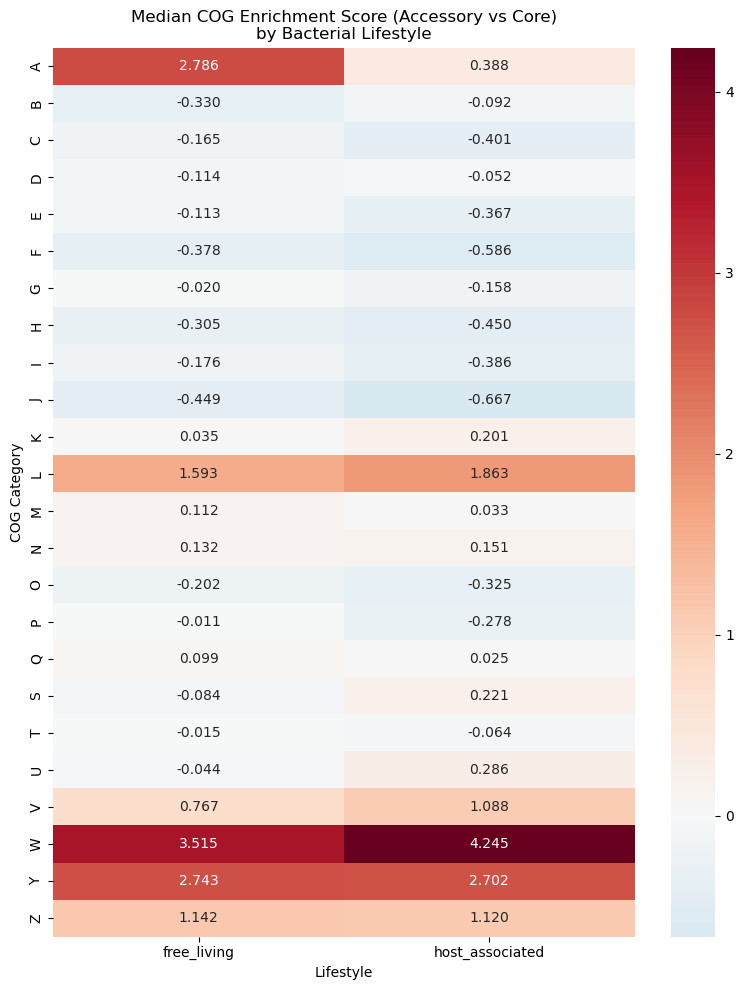

Saved: ../figures/enrichment_heatmap.png


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap: median enrichment score per COG category per lifestyle
pivot = enrichment.groupby(
    ['species_lifestyle', 'COG_category']
)['enrichment_score'].median().reset_index()

pivot_wide = pivot.pivot(index='COG_category', columns='species_lifestyle', values='enrichment_score')
pivot_wide = pivot_wide.reindex(sorted(pivot_wide.index))

fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(
    pivot_wide, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
    xticklabels=True, yticklabels=True, ax=ax
)
ax.set_title('Median COG Enrichment Score (Accessory vs Core)\nby Bacterial Lifestyle')
ax.set_ylabel('COG Category')
ax.set_xlabel('Lifestyle')
plt.tight_layout()
plt.savefig('../figures/enrichment_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: ../figures/enrichment_heatmap.png")

In [12]:
# Save full enrichment data
enrichment.to_csv('../data/cog_enrichment_by_lifestyle.csv', index=False)
stats_df.to_csv('../data/cog_lifestyle_stats.csv', index=False)
print(f"Saved enrichment data: {len(enrichment):,} rows")
print(f"Saved stats: {len(stats_df)} COG categories tested")

Saved enrichment data: 53,339 rows
Saved stats: 24 COG categories tested


## Results

Record findings here after running:

- **H1 (Defense V enrichment)**: ___
- **H2 (Metabolic diversity)**: ___
- **H3 (Core fraction)**: ___
- Most significant COG categories: ___
- Any unexpected patterns? ___
- Annotation coverage concerns? ___